# The Goal of this Project is to code a classifier and regressor decision tree that can be used with the following API:

```
df = pd.read_csv("data.csv")

train_df, test_df = sp.train_test_split(df, test_size = 0.2)
tree = dt.train(train_df)
predictions = dt.predict(test_df, tree)
accuracy = dt.calculate_accuracy(predictions, tree)

```

The algorithm that is going to be implemented looks like this:

<img src="https://raw.githubusercontent.com/SebastianMantey/Decision-Tree-from-Scratch/master/images/decision_tree_algorithm_1.png" width="350">

## Now After creating all the helper specialized functions and distribute them as one module we are ready to build the main tree algorithm. The tree will take the shape of the dictionary datastructure , the tree dict will have only one key and value , the key is a node question , its value is a list contains basically the two branches , a branch can be either a classification or another subtree (another dict).


In [765]:
from typing import Dict, Any


example_tree = {"petal_width <= 0.8": ["Iris-setosa",
                                       {"petal_width <= 1.65": [{"petal_length <= 4.9": ["Iris-versicolor",
                                                                                         "Iris-virginica"]},
                                                                "Iris-virginica"]}]}

## Import Statements


In [766]:
import pandas as pd
from pprint import pprint
import random
import matplotlib.pyplot as plt
import seaborn as sns
# main algorithm depends on the specialized functions
import special_functions as sp


# Load and Prepare Data

#### Format of the data
- the last column of the data frame must contain the label and it must also be called "label"
- there should be no missing values in the data frame

In [767]:
df = pd.read_csv("../data/Iris.csv")
df = df.drop("Id", axis=1)
df = df.rename(columns={"species": "label"})
data = df.values

In [768]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## Train-Test-Split

In [769]:
random.seed(0)
train_df, test_df = sp.train_test_split(df, test_size = 20)

# Decision Tree Algorithm

In [770]:
def type_of_features(df, values_threshold = 5):
    """
    this api function return a tuple contain each feature type (continuous , categorical )
    :param values_threshold: the threshold of unique vals to consider the features categorical
    :param df: the data frame to determine its features types
    :return: sorted tuple contains each feature type
    """
    feature_types = []

    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= values_threshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")

    return tuple(feature_types)

In [771]:
def dt_train(df, ml_task , counter = 0 , min_samples=2 , max_depth=5 , ) -> str | dict:
    """
    This is the main functions that performs recursion algorithm to train and return a decision tree
     the tree in a shape of dict datastructure. don't use the counter parameter,
     the algorithm only uses it to handle the recursion in the most optimized way.
    :param df: the pandas data frame to train the tree
    :param counter: (no for user )
    :param max_depth: the maximum depth of the tree
    :param min_samples: the min sample in a leaf
    :return: a tree data structure build on a dict
    """
    global FEATURES_NAMES # a global var to store the feature names from first iteration

    # data preparations
    if counter == 0:  # when counter is 0 the function called for the first time with a pandas data frame
        # this is global vars for the features names and types
        FEATURES_NAMES = df.columns
        sp.FEATURE_TYPES = type_of_features(df)
        data = df.values

    # we convert it to numpy data array as all our algorithms runs on it
    #     counter not 0 means that recursion hasn't done yet
    else:
        data = df

    # base cases to stop recursion is when the splot data is pure,
    # or we reach the maximum depth or when collect the minimum number required as data samples
    if (sp.check_purity(data)) or (counter == max_depth) or (len(data) < min_samples):
        return sp.make_leaf(data , ml_task)


    # recursive part of the algorithm
    else:
        # counter will be used to get depth information
        counter += 1
        # dependencies on specialized functions
        split_feature_index, split_value = sp.fit_best_split(data,ml_task) # first decide (fit best)
        # the most informatic feature and value

        # to split the node on
        data_below, data_above = sp.split_data(data, split_feature_index, split_value) # make the split

        # check for empty data
        if len(data_below) == 0 or len(data_above) == 0:
            return sp.make_leaf(data, ml_task)


        feature_name = FEATURES_NAMES[split_feature_index]
        feature_type = sp.FEATURE_TYPES[split_feature_index]
        # instantiate the question and the subtree(s)
        # for both continuous and categorical features
        if feature_type == "continuous":
            question = f"{feature_name} <= {split_value}"
        else:
            question = f"{feature_name} = {split_value}"

        sub_tree = {question: []}

        # find answers (in recursion way)
        yes_answer = dt_train(data_below,ml_task, counter , min_samples, max_depth)

        no_answer = dt_train(data_above, ml_task, counter , min_samples, max_depth)
        # respond to the caller with the answers

        if yes_answer == no_answer: # to prevent the tree from creating such identical branches
            sub_tree = yes_answer
        else:
            sub_tree[question].append(yes_answer)
            sub_tree[question].append(no_answer)

        return sub_tree

### API Testing
- we already know from the prev notebook that the feature of the petal_width mainly separate the iris-setosa flowers than other at about 0.6 of width , by removing the third class we know that the rest two classes can be mainly split on the root node.
- so we predict that our algorithm to return a dict contains two strings (the classes names).

In [772]:
dt_train(df[df.label != 'Iris-virginica'] , 'classification')



{'petal_width <= 0.6': ['Iris-setosa', 'Iris-versicolor']}

#### Let's build the tree upon the whole data frame

{'petal_width <= 0.6': ['Iris-setosa',
                        {'petal_width <= 1.7': [{'petal_length <= 4.9': [{'petal_width <= 1.6': ['Iris-versicolor',
                                                                                                 'Iris-virginica']},
                                                                         {'petal_width <= 1.5': ['Iris-virginica',
                                                                                                 {'petal_length <= 5.1': ['Iris-versicolor',
                                                                                                                          'Iris-virginica']}]}]},
                                                {'petal_length <= 4.8': [{'sepal_width <= 3.0': ['Iris-virginica',
                                                                                                 'Iris-versicolor']},
                                                                         'Iris-virginica']}]}

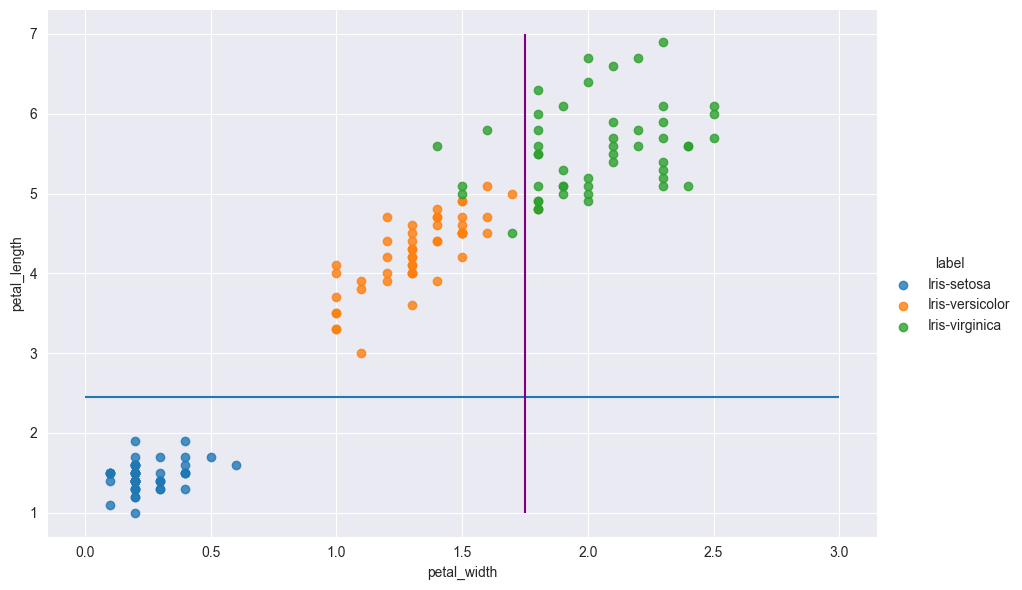

In [773]:
pprint(dt_train(df,'classification'))
sns.lmplot(data = df ,x = "petal_width",y='petal_length',hue='label',fit_reg = False , height  = 6 , aspect = 1.5 )
plt.hlines(y = 2.45 , xmin = 0 , xmax = 3 )
plt.vlines(x = 1.75 , ymin = 1 , ymax = 7 ,colors="purple")

# Classification

#### If we pick an sample (row) from the test data frame ...

In [774]:
example = test_df.iloc[0]
example

sepal_length                5.1
sepal_width                 2.5
petal_length                3.0
petal_width                 1.1
label           Iris-versicolor
Name: 98, dtype: object

#### We are to create a specialized function its main jop to classify one sample based on a tree given to it.

In [775]:
def predict_sample(sample, tree):
    """
    this API function classify one sample passed to it based on a given tree structure.
    :param sample: the sample to be classified
    :param tree: the tree structure to classify on
    :return: string a class name
    """
    # the question of the node is the key of the dict
    question = list(tree.keys())[0]

    # feature <= split_value
    # we split the attributes form the key
    feature_name, comparison_operator, value = question.split(" ")

    # ask question logically

    if comparison_operator == '<=':  # the feature is continuous
        if sample[feature_name] <= float(value):
            # the answer of yes leads to right branch
            answer = tree[question][0]
        else:
            # No leads to the left
            answer = tree[question][1]


    else: # the feature is categorical
        if str(example[feature_name]) == value:
            answer = tree[question][0]
        else:
            answer = tree[question][1]


    # base case to recurse in a subtree of return a class name
    if not isinstance(answer, dict):
        # answer is a class name
        return answer

    # recursive part , answer is another tree
    else:
        residual_tree = answer # answer is a subtree
        return predict_sample(sample, residual_tree)

In [776]:
tree = dt_train(train_df , max_depth=3 ,  ml_task= 'class')
pprint(tree)
sample = test_df.iloc[2]
pprint(sample)
predict_sample(sample,tree)

{'petal_width <= 0.6': ['Iris-setosa',
                        {'petal_width <= 1.6': [{'petal_length <= 4.9': ['Iris-versicolor',
                                                                         'Iris-virginica']},
                                                'Iris-virginica']}]}
sepal_length            5.4
sepal_width             3.7
petal_length            1.5
petal_width             0.2
label           Iris-setosa
Name: 10, dtype: object


'Iris-setosa'

## Predict & Calculate Accuracy

#### we are now ready to make a prediction on any test data frame , based of the learned tree in the help of the prev function

In [777]:
def dt_predict(df , tree , ml_task):
    """
    This API function predict the classification of a pandas data frame based on a trained tree,
    Only used with classifier tree

    :param df: the test pandas data frame
    :param tree: a trained tree to classify and predict on
    :return: a pandas data frame with new two columns,
    classification and prediction_correct
    """
    # add the classification col and apply the classify_sample function to each of its rows
    ret_df = df.copy()
    if ml_task != 'regression':
        ret_df["classification"] = df.apply(predict_sample, axis=1, args=(tree,))
        # add the prediction_correct col and set its values to booleans of the matching with the actual labels
        ret_df["prediction_correct"] = ret_df["classification"] == df["label"]
    elif ml_task == 'regression':
        ret_df["regression"] = df.apply(predict_sample, axis=1, args=(tree,))

    return ret_df

### API Testing

In [778]:
trained_tree = dt_train(train_df,max_depth=3 , ml_task='class')
predicted_df = dt_predict(test_df,trained_tree,'classification')
pprint(trained_tree)
predicted_df

{'petal_width <= 0.6': ['Iris-setosa',
                        {'petal_width <= 1.6': [{'petal_length <= 4.9': ['Iris-versicolor',
                                                                         'Iris-virginica']},
                                                'Iris-virginica']}]}


,sepal_length,sepal_width,petal_length,petal_width,label,classification,prediction_correct
98,5.1,2.5,3.0,1.1,Iris-versicolor,Iris-versicolor,True
107,7.3,2.9,6.3,1.8,Iris-virginica,Iris-virginica,True
10,5.4,3.7,1.5,0.2,Iris-setosa,Iris-setosa,True
66,5.6,3.0,4.5,1.5,Iris-versicolor,Iris-versicolor,True
130,7.4,2.8,6.1,1.9,Iris-virginica,Iris-virginica,True
124,6.7,3.3,5.7,2.1,Iris-virginica,Iris-virginica,True
103,6.3,2.9,5.6,1.8,Iris-virginica,Iris-virginica,True
77,6.7,3.0,5.0,1.7,Iris-versicolor,Iris-virginica,False
122,7.7,2.8,6.7,2.0,Iris-virginica,Iris-virginica,True
91,6.1,3.0,4.6,1.4,Iris-versicolor,Iris-versicolor,True


## Now we want such API that enables us to get the Accuracy of the predicted classifications and the r_squared for the predicted regression.

In [779]:
### Accuracy

In [780]:
def dt_calculate_accuracy(df):
    """
    This api function to calculate the accuracy of predicted classification from predict api.
    Only used with a classifier tree
    :param df: the pandas data frame returned from the dt_predict api
    :return: a float number represent the accuracy of the prediction
    """
    # accuracy is just the mean value of the binaries
    # in the prediction_correct col
    accuracy = df["prediction_correct"].mean()

    return accuracy

In [781]:
train_df , test_df = sp.train_test_split(df , test_size=0.2)
tree = dt_train(train_df,max_depth=3, ml_task='class')
predicted_df = dt_predict(test_df, tree)

accuracy = dt_calculate_accuracy(predicted_df)
print(f'the accuracy of prediction is {accuracy:3}')
predicted_df

TypeError: dt_predict() missing 1 required positional argument: 'ml_task'

### r_squared

In [ ]:
def calculate_r_squared(df, tree):
    labels = df.label
    mean = labels.mean()
    predictions = df.apply(predict_sample, args=(tree,), axis=1)

    ss_res = sum((labels - predictions) ** 2)
    ss_tot = sum((labels - mean) ** 2)
    r_squared = 1 - ss_res / ss_tot

    return r_squared

##  Hyperparameter Tuning

#### Its essential that our module contains an API function to tune the parameter of the tree like min__samples and max_depth , the parameters are optimized based on the accuracy for the classification and on r_squared based for regression.


In [ ]:
def dt_tune_parameters(df , ml_task):
    if ml_task == 'regression':
        train_df , val_df = sp.train_test_split(df , test_size=0.3)
        grid_search = {"max_depth": [], "min_samples": [], "r_squared_train": [], "r_squared_val": []}
        for max_depth in range(1, 7):
            for min_samples in range(5, 20, 5):
                tree = dt_train(train_df, ml_task="regression", max_depth=max_depth, min_samples=min_samples)

                r_squared_train = calculate_r_squared(train_df, tree)
                r_squared_val = calculate_r_squared(val_df, tree)

                grid_search["max_depth"].append(max_depth)
                grid_search["min_samples"].append(min_samples)
                grid_search["r_squared_train"].append(r_squared_train)
                grid_search["r_squared_val"].append(r_squared_val)

    else: # task is classification
        grid_search = {"max_depth": [], "min_samples": [], "accuracy": []}
        for max_depth in range(1, 7):
            for min_samples in range(5, 20, 5):
                tree = dt_train(df, ml_task="classification", max_depth=max_depth, min_samples=min_samples)

                accuracy = dt_calculate_accuracy(dt_predict(df , tree , 'classification'))


                grid_search["max_depth"].append(max_depth)
                grid_search["min_samples"].append(min_samples)
                grid_search["accuracy"].append(accuracy)

    grid_search = pd.DataFrame(grid_search)
    return  grid_search.sort_values("r_squared_val", ascending=False)
